## Setup

In [1]:
import numpy as np
import pandas as pd
#import keras
#from keras import layers
#from matplotlib import pyplot as plt
#import numpy as np
import matplotlib.pyplot as plt
#from cycler import cycler
import scipy.special as sp
import os as os
#import pywt as py
#import statistics as st
import os as os
#import random
import multiprocessing
from joblib import Parallel, delayed
#import platform
from time import time as ti
from skimage.restoration import denoise_wavelet
#import tensorflow as tf
import pickle
#import CoreFunctions as cf

import sys

DataFolder = '/scratch/Recordings2/'
SaveFolder = '/scratch/750inputs/'
#DataFolder = '/sciclone/scr10/dchendrickson01/Recordings2/'
#SaveFolder = '/sciclone/scr10/dchendrickson01/Ninputs/'

StartPoint = 0
Groups = 180
#StartPoint = int(sys.argv[1])
#Groups = 186

verbose = True
small = False
noise = verbose

TIME_STEPS = 750
Skips = 50

tic = ti()
start = tic

In [2]:
def RollingStdDev(RawData, SmoothData, RollSize = 25):
    StdDevs = []
    for i in range(RollSize):
        Diffs = RawData[0:i+1]-SmoothData[0:i+1]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / (i+1)
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)
    for i in range(len(RawData)-RollSize-1):
        j = i + RollSize
        Diffs = RawData[i:j]-SmoothData[i:j]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / RollSize
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)  
    
    return StdDevs

def RollingStdDevFaster(RawData, SmoothData, RollSize = 25):

    Diffs = RawData - SmoothData
    
    del RawData, SmoothData
    
    Sqs = Diffs * Diffs

    del Diffs
    
    Sqs = Sqs.tolist() 
    
    Sqs.extend(np.zeros(RollSize))
    
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    
    del mSqs, Sqs
    
    VarVect = sVect / eVect
    
    StdDevs = np.sqrt(VarVect)
    
    return StdDevs[:-RollSize]


def RollingSum(Data, Length = 100):
    RollSumStdDev = []
    for i in range(Length):
        RollSumStdDev.append(sum(Data[0:i+1]))
    for i in range(len(Data) - Length):
        RollSumStdDev.append(sum(Data[i:i+Length]))
    return RollSumStdDev

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02, verbose = False):
    
    SquelchSignal = np.ones(len(DataSet))
    if verbose:
        print(len(SquelchSignal))
        
    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def SquelchPatternFast(DataSet, StallRange = 5000, SquelchLevel = 0.02):
    SquelchSignal = np.ones(len(DataSet))

    #DataSet = DataSet.tolist() 
    
    DataSet.extend(np.zeros(StallRange))
    
    DSM = np.matrix(DataSet)
    
    for i in range(StallRange):
        DataSet.insert(0, DataSet.pop())
        DSM = np.concatenate((np.matrix(DataSet),DSM))
    
    DsmAvs = np.average(DSM,axis=0)
    
    DsmAvs[DsmAvs < SquelchLevel] = 0
    DsmAvs[DsmAvs >= SquelchLevel] = 1

    return SquelchSignal

def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    Acceleration -= np.average(Acceleration)
    
    if len(Timestamps) == 1:
        dTime = np.ones(len(Acceleration),dtype=float) * Timestamps
    elif len(Timestamps) == len(Acceleration):
        dTime = np.zeros(len(Timestamps), dtype=float)
        dTime[0]=1
        for i in range(len(Timestamps)-1):
            j = i+1
            if float(Timestamps[j]) > float(Timestamps[i]):
                dTime[j]=float(Timestamps[j])-float(Timestamps[i])
            else:
                dTime[j]=float(Timestamps[j])-float(Timestamps[i])+10000.0
        dTime /= 10000.0

    velocity[0] = Acceleration[0] * (dTime[0])

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime[j]                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime[j]

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity

def MakeDTs(Seconds, Miliseconds):
    dts = np.zeros(len(Miliseconds), dtype=float)
    dts[0]=1
    for i in range(len(MiliSeconds)-1):
        j = i+1
        if Seconds[j]==Seconds[i]:
            dts[j]=Miliseconds[j]-Miliseconds[i]
        else:
            dts[j]=Miliseconds[j]-Miliseconds[i]+1000
    dts /= 10000
    return dts


def split_list_by_ones(original_list, ones_list):
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, goin to use fo rlong lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, skips = Skips):
    output = []
    for i in range(int((len(values) - time_steps + skips)/skips)):
        output.append(values[i*skips : (i*skips + time_steps)])
    return np.stack(output)

In [3]:
def runFile(file, verbose = False, small = False, index=0, start=ti()):
    noise = verbose
    if file[-4:] == '.csv':    
        dataset = pd.read_csv(DataFolder+file, delimiter =",", header=None, engine='python',on_bad_lines='skip')
        if noise:
            print("File Read", ti()-start)
        dataset = dataset.rename(columns={0:"Day"})
        dataset = dataset.rename(columns={1:"Second"})
        dataset = dataset.rename(columns={2:"FracSec"})
        dataset = dataset.rename(columns={3:"p"})
        dataset = dataset.rename(columns={4:"h"})
        dataset = dataset.rename(columns={5:"v"})
        dataset = dataset.rename(columns={6:"Sensor"})

        dataset['Second'].replace('',0)
        dataset['FracSec'].replace('',0)
        dataset.replace([np.nan, np.inf, -np.inf],0,inplace=True)
        
        dataset[['Day','Second']] = dataset[['Day','Second']].apply(lambda x: x.astype(int).astype(str).str.zfill(6))
        dataset[['FracSec']] = dataset[['FracSec']].apply(lambda x: x.astype(int).astype(str).str.zfill(4))

        dataset["timestamp"] = pd.to_datetime(dataset.Day+dataset.Second+dataset.FracSec,format='%y%m%d%H%M%S%f')
        dataset["timestamps"] = dataset["timestamp"]

        dataset["p"] = dataset.p - np.average(dataset.p)
        dataset["h"] = dataset.h - np.average(dataset.h)
        dataset["v"] = dataset.v - np.average(dataset.v)
        dataset["r"] = np.sqrt(dataset.p**2 + dataset.h**2 + dataset.v**2)

        dataset.index = dataset.timestamp

        dataset["SmoothP"] = denoise_wavelet(dataset.p, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothH"] = denoise_wavelet(dataset.h, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothV"] = denoise_wavelet(dataset.v, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothR"] = denoise_wavelet(dataset.r, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')

        if noise:
            print("Data Cleaned", ti()-start, len(dataset.p))

        RawData = dataset.v
        SmoothData = dataset.SmoothV
        RollSize = 25

        Diffs = RawData - SmoothData

        Sqs = Diffs * Diffs

        Sqs = Sqs.tolist() 

        Sqs.extend(np.zeros(RollSize))

        mSqs = np.matrix(Sqs)

        for i in range(RollSize):
            Sqs.insert(0, Sqs.pop())
            mSqs = np.concatenate((np.matrix(Sqs),mSqs))

        sVect = mSqs.sum(axis=0)
        eVect = (mSqs!=0).sum(axis=0)

        VarVect = sVect / eVect

        StdDevs = np.sqrt(VarVect)

        StdDevsZ = np.asarray(StdDevs)

        StdDevsZ=np.append(StdDevsZ,[0])

        StdDevsZ = np.asarray(StdDevsZ.T[:len(dataset.p)])

        if noise:
            print("Size StdDevsZ", ti()-start, np.shape(StdDevsZ))

        #StdDevsZ = np.nan_to_num(StdDevsZ)

        #StdDevsZ[StdDevsZ == np.inf] = 0
        #StdDevsZ[StdDevsZ == -np.inf] = 0

        if noise:
            print("cleaned", ti()-start, np.shape(StdDevsZ))

        SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet='sym2', rescale_sigma='True')

        if noise:
            print("denoise 1", ti()-start, np.shape(StdDevsZ))

        #SmoothDevZa = cf.Smoothing(StdDevsZ, 3, wvt='sym2', dets_to_remove=2, levels=3)
        #SmoothDevZ = np.ravel(SmoothDevZ[0,:])

        #SmoothDevZ = SmoothDevZ.tolist()

        if noise:
            print("denoise 2", ti()-start, np.shape(SmoothDevZ))

        #ataset["SmoothDevZ"] = SmoothDevZ

        SmoothDevZ[np.isnan(SmoothDevZ)]=0
        
        Max = np.max(SmoothDevZ)

        
        
        if noise:
            print("Max", ti()-start, np.shape(Max), Max)

        buckets = int(Max / 0.005) + 1
        bins = np.linspace(0,buckets*0.005,buckets+1)
        counts, bins = np.histogram(SmoothDevZ,bins=bins)

        CummCount = 0
        HalfWay = 0
        for i in range(len(counts)):
            CummCount += counts[i]
            if CummCount / len(SmoothDevZ) >= 0.5:
                if HalfWay == 0:
                    HalfWay = i

        SquelchLevel = bins[HalfWay] 
        if noise:
            print("SmoothDevz size", np.shape(SmoothDevZ))

        dataset["IsMoving"] = SquelchPattern(SmoothDevZ, 4000, SquelchLevel, verbose=noise)

        if noise:
            print("Squelch Made", ti()-start)
        #dataset["velocity"] = getVelocity(dataset.p, dataset.FracSec, dataset.IsMoving, 2)
        #if noise:
        #    print("Velocity Calculated.  File done: ",file)

        #df_pr = split_list_by_ones(dataset.p, dataset.IsMoving)
        #df_hr = split_list_by_ones(dataset.h, dataset.IsMoving)
        #df_vr = split_list_by_ones(dataset.v, dataset.IsMoving)
        #df_rrr = split_list_by_ones(dataset.r, dataset.IsMoving)
        df_ps = split_list_by_ones(dataset.SmoothP, dataset.IsMoving)
        df_hs = split_list_by_ones(dataset.SmoothH, dataset.IsMoving)
        df_vs = split_list_by_ones(dataset.SmoothV, dataset.IsMoving)
        df_rs = split_list_by_ones(dataset.SmoothR, dataset.IsMoving)

        MatsSmooth = []
        for i in range(len(df_ps)):
            MatsSmooth.append(np.vstack((df_ps[i],df_hs[i],df_vs[i],df_rs[i])))
        
        if verbose:
            print("Split by ones", ti()-start)


        '''df_p=[0]
        df_h=[0]
        df_v=[0]
        df_r=[0]
        df_rp=[0]
        df_rh=[0]
        df_rv=[0]
        df_rr=[0]
        for i in range(len(df_ps)):
            df_p += df_ps[i]
            df_h += df_hs[i]
            df_v += df_vs[i]
            df_r += df_rs[i]
            df_rp += df_pr[i]
            df_rh += df_hr[i]
            df_rv += df_vr[i]
            df_rr += df_rrr[i]
        '''
        if verbose:
            print('format changed', ti()-start, np.shape(df_p))

        return MatsSmooth
    else:
        return ['fail','fail']
        
        #if verbose:
        #    print('Data normalized', ti()-start)

        #return df_p, df_h, df_v, df_r, df_rp, df_rh, df_rv, df_rr


In [4]:
files= os.listdir(DataFolder) 
#Results = Parallel(n_jobs=8)(delayed(runFile)(file, False, False, index) for index, file in enumerate(files))

%%time
df_p, df_h, df_v, df_r, df_rp, df_rh, df_rv, df_rr = runFile(files[3], verbose = False, small = False, index=0, start=ti())

print(len(df_p),len(df_h),len(df_v),len(df_r),
      len(df_rp),len(df_rh),len(df_rv),len(df_rr))

In [5]:
def getData(offset, loops = 20, starts=ti()):
    ListOfMats = []
    for i in range(loops):
        Mats = runFile(files[i*3+offset], verbose = False, small = False, index=0, start=starts)
        if len(Mats)> 20:
            ListOfMats.append(Mats)
        #print(i, int((ti()-starts)/60*100)/100, len(Mats))
    return ListOfMats


In [6]:
AllDatas = Parallel(n_jobs=6)(delayed(getData)(i,2,ti()) for i in range(3))

In [7]:
Mats=[]
for Data in AllDatas:
    for Mat in Data:
        for run in Mat:
            Mats.append(run)

In [8]:
del AllDatas

In [8]:
len(Mats)

3568

In [10]:
np.shape(Mats[156])

(4, 2761)

In [11]:
lengths=[]
rejects=[]

In [46]:
Originals = []
Smoothed = []

small = 12000
large = 16000

In [47]:

for move in Mats:
    leng = np.shape(move)[1]
    if (leng < large and leng > small):
        lengths.append(leng)
    else:
        rejects.append(leng)

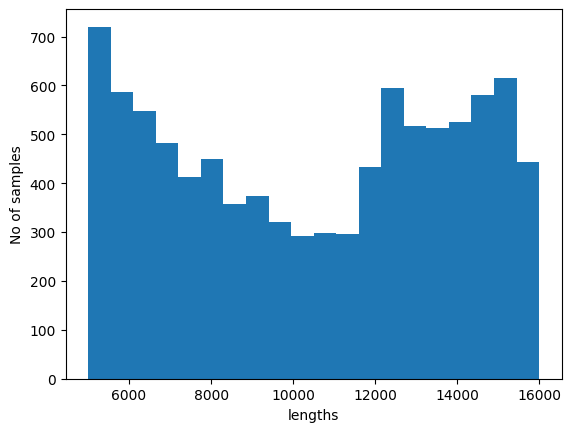

In [48]:
plt.hist(lengths, bins=20)
plt.xlabel("lengths")
plt.ylabel("No of samples")
plt.show()


In [49]:
len(lengths) / (len(lengths)+len(rejects))

0.0887887697998672

In [50]:
len(lengths)

9361

In [51]:
np.average(lengths)

10498.717978848414

groups = [2250-3000,
          3001-5000, 
          5001-7500, 
          7501-10000,
          10001-15000,
          15001-20000,
          20001-30000,
          30001-50000,
          50001-75000,
          75001-100000]

In [52]:
for j, move in enumerate(Mats):
    moveSize = np.shape(move)[1]
    if (moveSize < large and moveSize > small):
        extra = large - moveSize
        sPad = 0 #int(extra/2)
        ePad = extra # int(extra/2)+(extra%2)
        Smoothed.append(np.vstack((np.pad(move[0,:], (sPad, ePad), mode='constant', constant_values=np.average(move[0,:])),
                                   np.pad(move[1,:], (sPad, ePad), mode='constant', constant_values=np.average(move[1,:])),
                                   np.pad(move[2,:], (sPad, ePad), mode='constant', constant_values=np.average(move[2,:])),
                                   np.pad(move[3,:], (sPad, ePad), mode='constant', constant_values=np.average(move[3,:])))
                                  ).T
                        )
        '''
        Originals.append(np.vstack((np.pad(l_rp[i][j], (sPad, ePad), mode='constant', constant_values=np.average(l_rp[i][j])),
                                   np.pad(l_rh[i][j], (sPad, ePad), mode='constant', constant_values=np.average(l_rh[i][j])),
                                   np.pad(l_rv[i][j], (sPad, ePad), mode='constant', constant_values=np.average(l_rv[i][j])),
                                   np.pad(l_rr[i][j], (sPad, ePad), mode='constant', constant_values=np.average(l_rr[i][j])))
                                  ).T
                        )
        '''

    else:
        rejects.append(moveSize)

In [53]:
np.shape(Smoothed)

(1988, 16000, 4)

<function matplotlib.pyplot.show(close=None, block=None)>

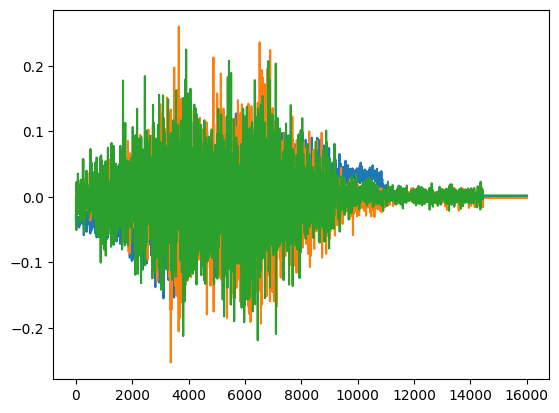

In [54]:
i = 112
fig = plt.figure()
plt.plot(Smoothed[i][:,0])
plt.plot(Smoothed[i][:,1])
plt.plot(Smoothed[i][:,2])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

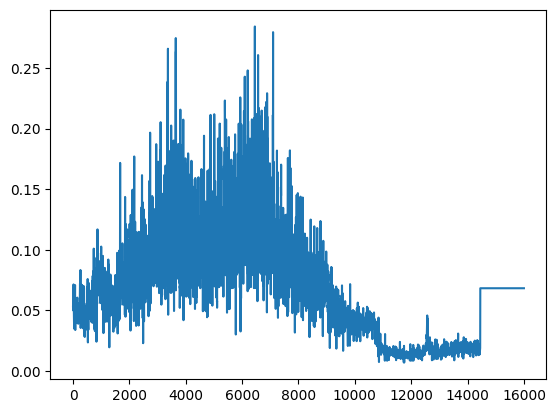

In [55]:
i = 112
fig = plt.figure()
plt.plot(Smoothed[i][:,3])
plt.show

In [22]:
import keras
from keras import layers, models

2024-09-10 12:45:08.724576: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 12:45:18.135103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

In [93]:
model = models.Sequential(
    [
        # Input layer
        layers.Input(shape=(large,3)),
        
        # Increased number of filters and added layers
        layers.Conv1D(filters=512, kernel_size=17, padding="same", strides=2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Conv1D(filters=256, kernel_size=11, padding="same", strides=2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Conv1D(filters=128, kernel_size=7, padding="same", strides=2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        
        # Dropout layer for regularization
        layers.Dropout(rate=0.3),
        
        # Transpose layers with increased filters
        layers.Conv1DTranspose(filters=128, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=256, kernel_size=11, padding="same", strides=2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Conv1DTranspose(filters=512, kernel_size=17, padding="same", strides=2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        
        # Dropout layer for regularization
        layers.Dropout(rate=0.3),
        
        # Output layer
        layers.Conv1DTranspose(filters=1, kernel_size=5, padding="same"),
        
        # Added dense layers with more neurons
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ]
)

In [25]:
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, save_freq):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.filepath.format(epoch=epoch + 1))


In [94]:
checkpoint_callback = CustomModelCheckpoint(
    filepath='/sciclone/scr10/dchendrickson01/models/BabySteps_20-30sMovesbigger-0911c-{epoch:02d}.keras',
    save_freq=1  
)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='/sciclone/scr10/dchendrickson01/models/profiles/0909-16000/',
                                            profile_batch='01, 256')

es_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=5, mode="min")

from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

2024-09-11 16:11:49.653982: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-09-11 16:11:49.654083: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-09-11 16:11:49.654448: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [95]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.02), loss="mse")
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 8000, 512)      │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 4000, 256)      │     1,442,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 2000, 128)      │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 4000, 128)      │       114,816 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_8              │ (None, 8000, 256)      │       360,704 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_9              │ (None, 16000, 512)     │     2,228,736 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16000, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_10             │ (None, 16000, 1)       │         2,561 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16000, 256)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16000, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16000, 1)       │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,438,530 (16.93 MB)

 Trainable params: 4,438,530 (16.93 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
ss = tf.convert_to_tensor(Smoothed, dtype=tf.float32)

In [59]:
inputs, outputs = tf.split(ss, [3, 1], axis=2)

In [60]:
np.shape(inputs)

TensorShape([1988, 16000, 3])

In [61]:
np.shape(outputs)

TensorShape([1988, 16000, 1])

In [96]:
history = model.fit(
    x=inputs,
    y=outputs,
    epochs=1000,
    batch_size=2,
    validation_split=0.1,
    callbacks=[checkpoint_callback, es_callback],# tb_callback],        
    )

Epoch 1/1000
895/895 ━━━━━━━━━━━━━━━━━━━━ 475s 527ms/step - loss: 2.3067 - val_loss: 0.0970
Epoch 2/1000
895/895 ━━━━━━━━━━━━━━━━━━━━ 464s 518ms/step - loss: 0.0754 - val_loss: 0.0406
Epoch 3/1000
895/895 ━━━━━━━━━━━━━━━━━━━━ 429s 479ms/step - loss: 0.0315 - val_loss: 0.0170
Epoch 4/1000
895/895 ━━━━━━━━━━━━━━━━━━━━ 446s 499ms/step - loss: 0.0169 - val_loss: 0.0118
Epoch 5/1000
895/895 ━━━━━━━━━━━━━━━━━━━━ 442s 494ms/step - loss: 0.0143 - val_loss: 0.0093
Epoch 6/1000
895/895 ━━━━━━━━━━━━━━━━━━━━ 410s 458ms/step - loss: 0.0113 - val_loss: 0.0143
Epoch 7/1000
895/895 ━━━━━━━━━━━━━━━━━━━━ 410s 458ms/step - loss: 0.0133 - val_loss: 0.0093
Epoch 8/1000
343/895 ━━━━━━━━━━━━━━━━━━━━ 4:01 437ms/step - loss: 0.0125

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [89]:
history = model.fit(
    x=inputs,
    y=outputs,
    epochs=10,
    batch_size=2,
    validation_split=0.1,
    callbacks=[checkpoint_callback, reduce_lr],# tb_callback],        
    )

Epoch 1/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 412s 461ms/step - loss: 231.3018 - val_loss: 211.7118 - learning_rate: 0.0100
Epoch 2/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 410s 458ms/step - loss: 348.3138 - val_loss: 184.8384 - learning_rate: 0.0100
Epoch 3/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 411s 459ms/step - loss: 178.2869 - val_loss: 158.7330 - learning_rate: 0.0100
Epoch 4/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 410s 458ms/step - loss: 152.3637 - val_loss: 133.5235 - learning_rate: 0.0100
Epoch 5/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 409s 457ms/step - loss: 127.4677 - val_loss: 109.7944 - learning_rate: 0.0100
Epoch 6/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 409s 458ms/step - loss: 104.2784 - val_loss: 88.5431 - learning_rate: 0.0100
Epoch 7/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 409s 457ms/step - loss: 83.8469 - val_loss: 70.8276 - learning_rate: 0.0100
Epoch 8/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 409s 457ms/step - loss: 67.0462 - val_loss: 57.0824 - learning_rate: 0.0100
Epoch 9/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 411s 459ms/step - los

In [33]:
model2 = keras.Sequential(
    [
        layers.Input(shape=(large,3)),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.02), loss="mse")
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 16000, 32)      │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16000, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 16000, 16)      │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 16000, 16)      │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16000, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 16000, 32)      │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 16000, 1)       │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,953 (38.88 KB)

 Trainable params: 9,953 (38.88 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
checkpoint_callback2 = CustomModelCheckpoint(
    filepath='/sciclone/scr10/dchendrickson01/models/BabySteps_20-30sMoves-0908b-{epoch:02d}.keras',
    save_freq=1  
)

tb_callback2 = tf.keras.callbacks.TensorBoard(log_dir='/sciclone/scr10/dchendrickson01/models/profiles/0908-16000/',
                                            profile_batch='01, 256')

es_callback2 = keras.callbacks.EarlyStopping(monitor="loss", patience=5, mode="min")

2024-09-10 17:18:18.684591: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-09-10 17:18:18.684830: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-09-10 17:18:18.685024: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [35]:
history2 = model2.fit(
    x=inputs,
    y=outputs,
    epochs=10,
    batch_size=2,
    #validation_split=0.1,
    callbacks=[checkpoint_callback, es_callback, tb_callback],        
    )

Epoch 1/10


2024-09-10 17:18:18.801844: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-09-10 17:18:18.801872: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


 255/3687 ━━━━━━━━━━━━━━━━━━━━ 1:51 33ms/step - loss: 0.0012

2024-09-10 17:18:28.931347: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.


 260/3687 ━━━━━━━━━━━━━━━━━━━━ 1:55 34ms/step - loss: 0.0012

2024-09-10 17:18:29.184177: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


3687/3687 ━━━━━━━━━━━━━━━━━━━━ 93s 25ms/step - loss: 0.0015
Epoch 2/10
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 88s 24ms/step - loss: 0.0015
Epoch 3/10
1093/3687 ━━━━━━━━━━━━━━━━━━━━ 1:02 24ms/step - loss: 0.0015

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



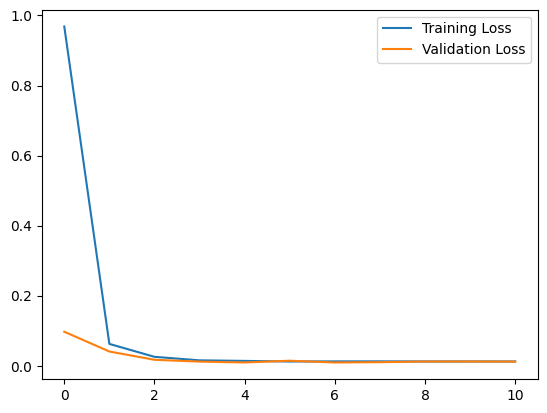

In [100]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [97]:
x_train_pred = model.predict(inputs)

63/63 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step


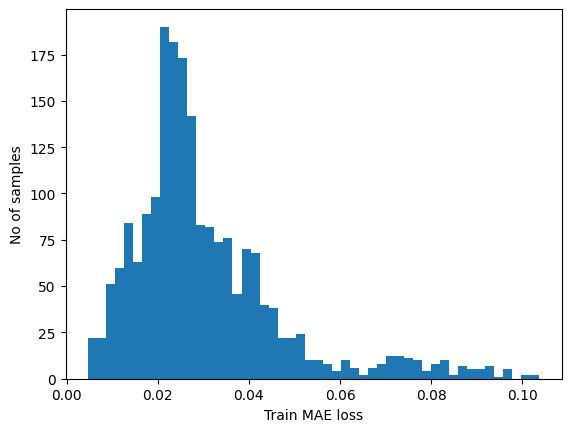

Reconstruction error threshold:  0.10369607


In [98]:
train_mae_loss = np.mean(np.abs(x_train_pred - outputs), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [38]:
x_train_pred2 = model2.predict(inputs)

231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step


In [39]:
np.shape(x_train_pred2)

(7373, 16000, 1)

In [40]:
train_mae_loss2 = np.mean(np.abs(x_train_pred2 - outputs), axis=1)

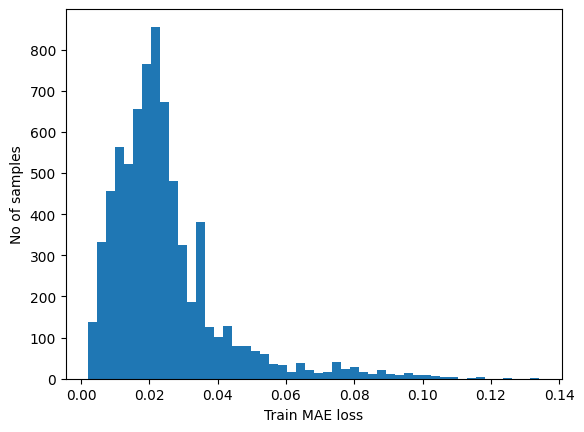

Reconstruction error threshold:  0.13414499


In [65]:
plt.hist(train_mae_loss2, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold2 = np.max(train_mae_loss2)
print("Reconstruction error threshold: ", threshold2)

In [42]:
np.shape(outputs)

TensorShape([7373, 16000, 1])

In [43]:
np.shape(x_train_pred2)

(7373, 16000, 1)

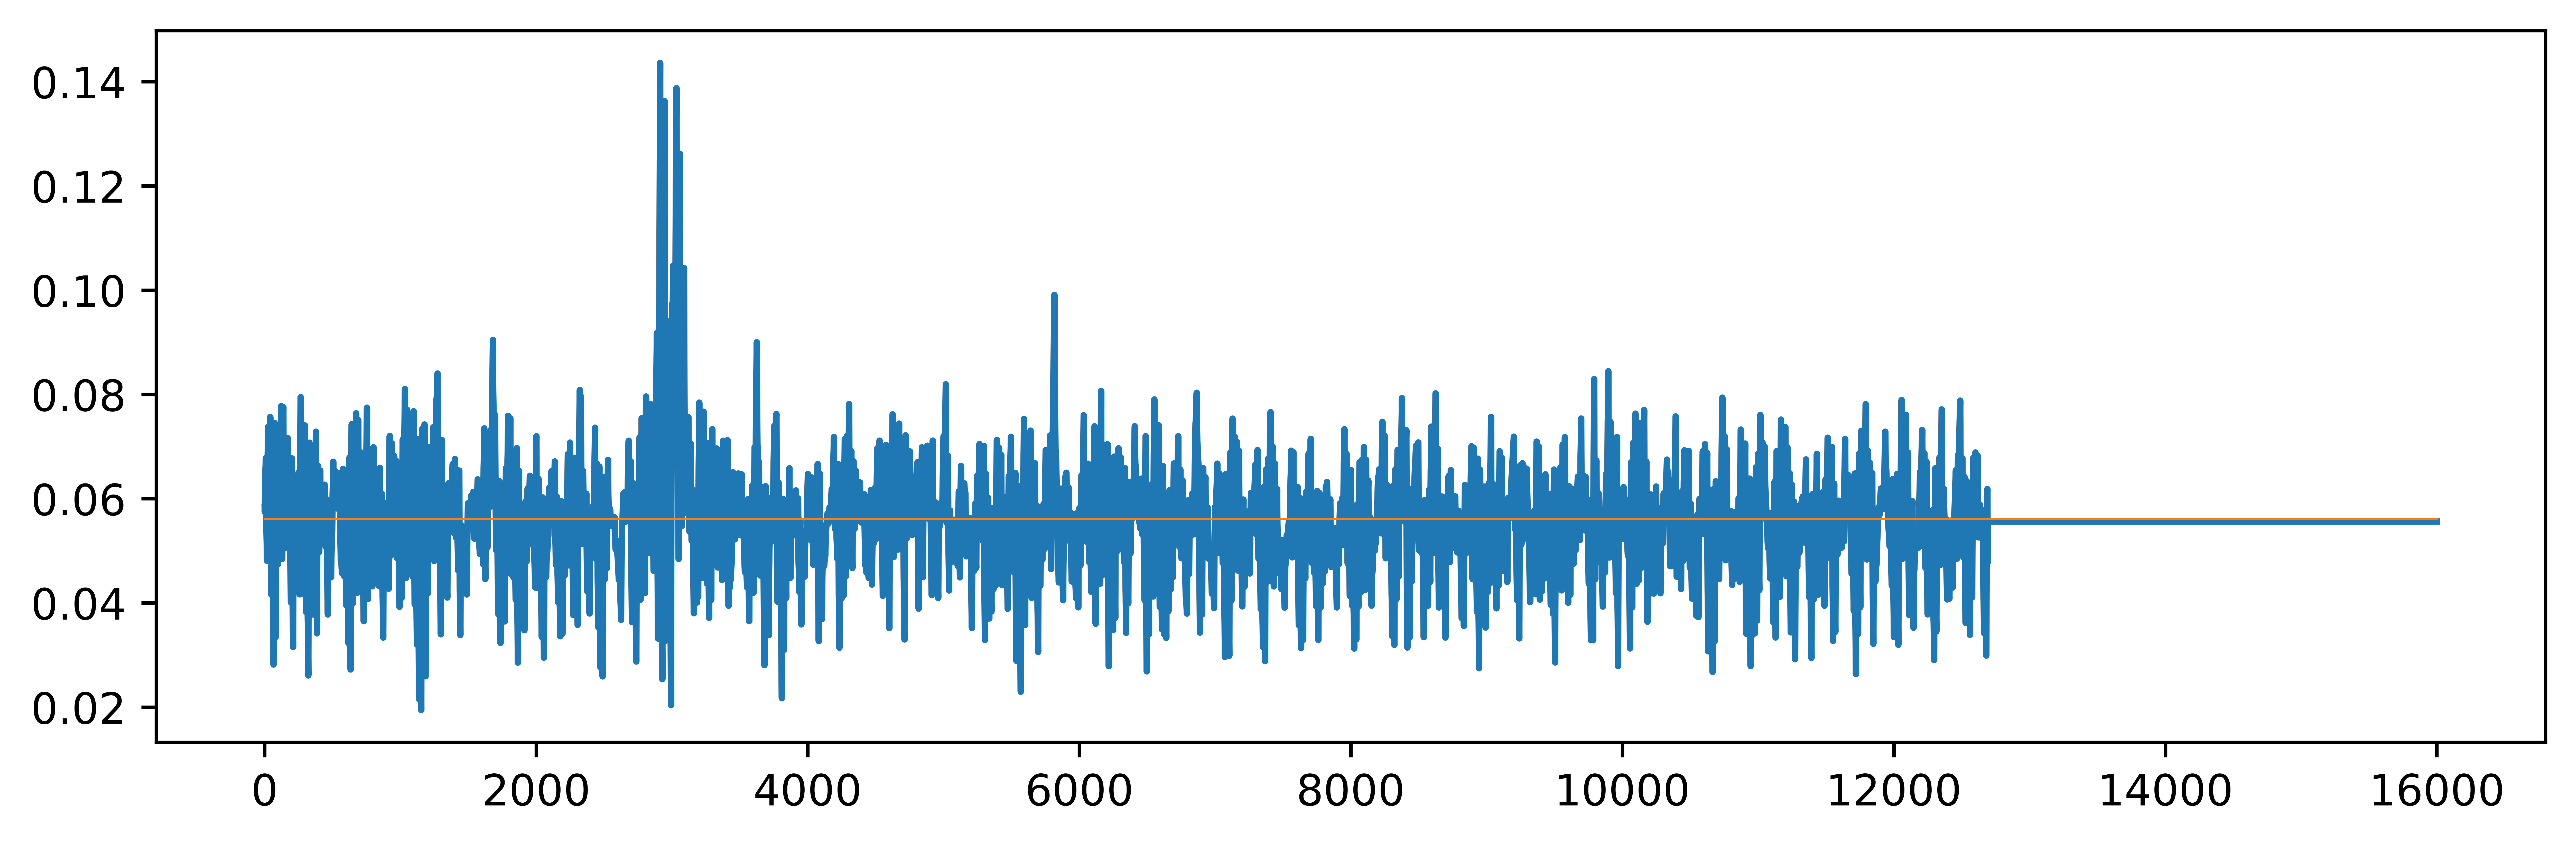

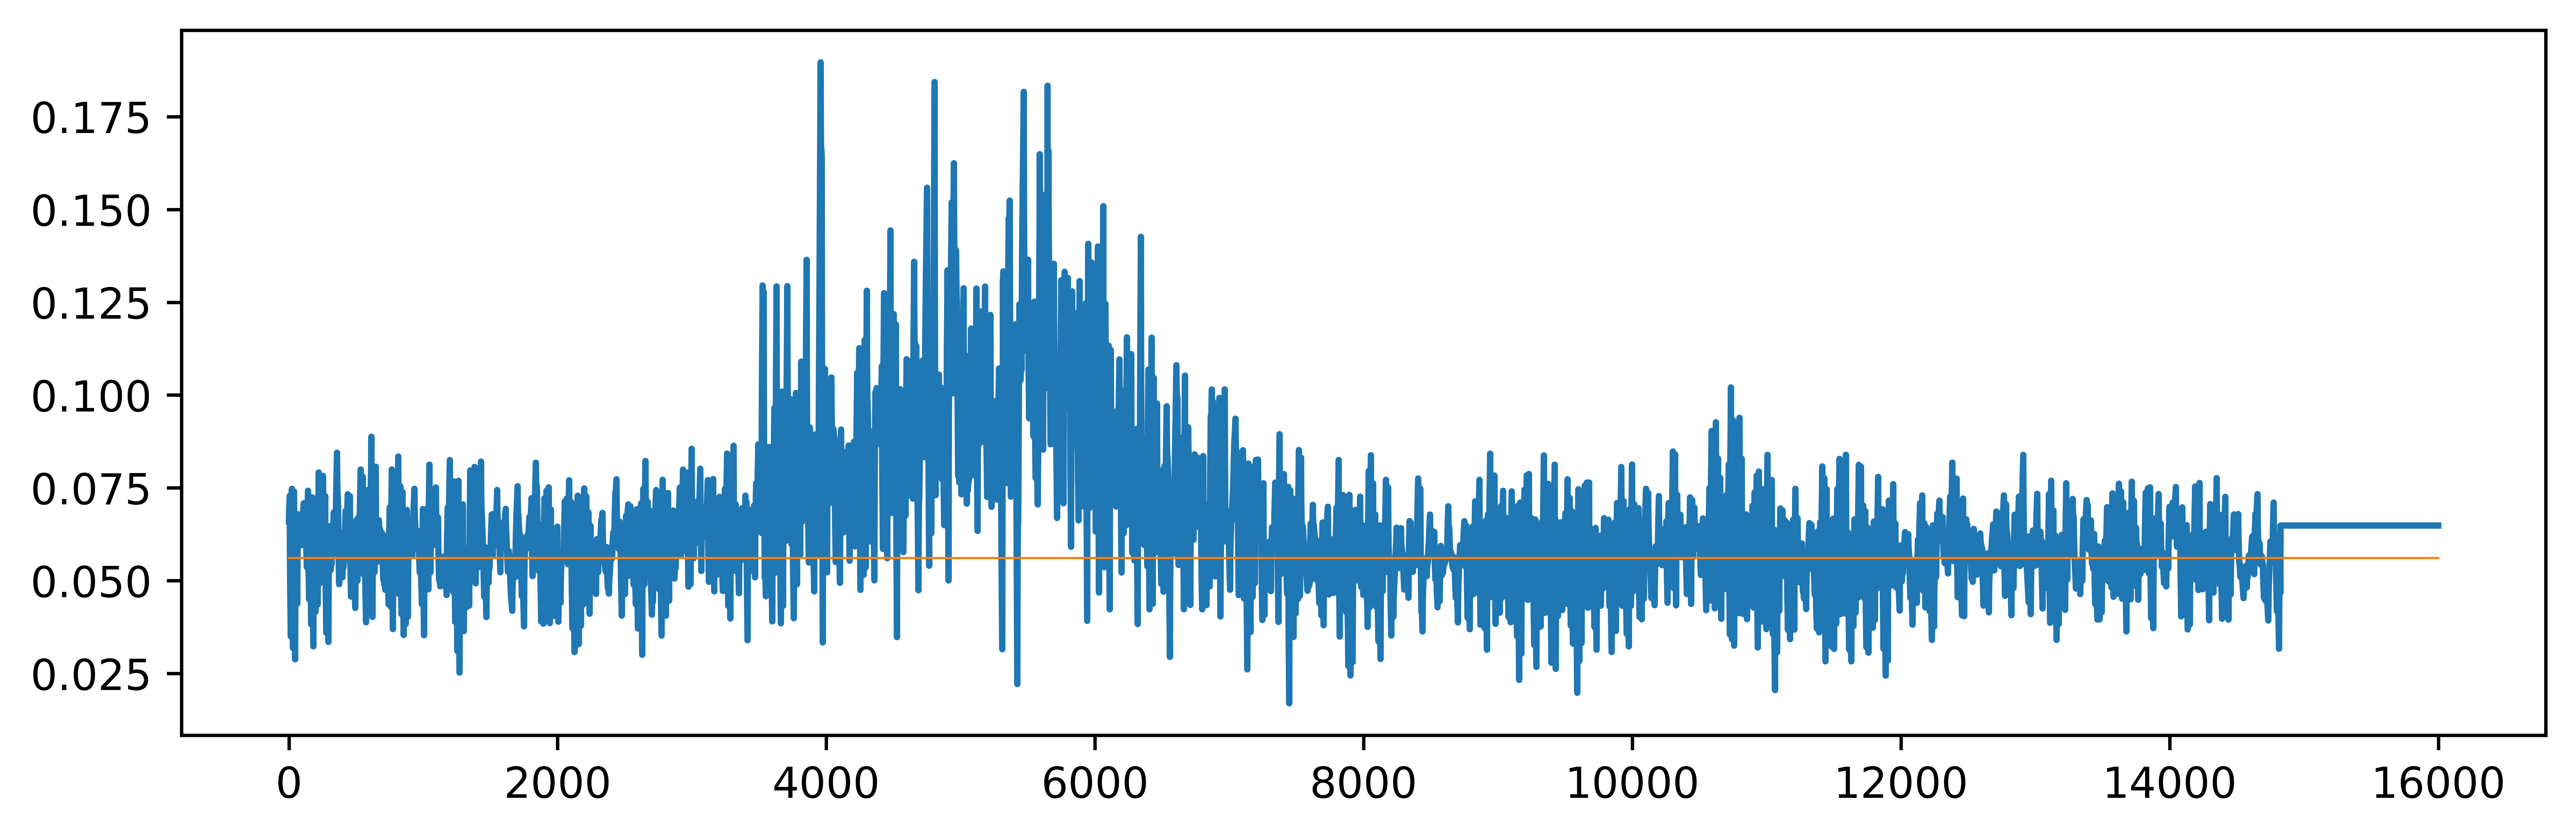

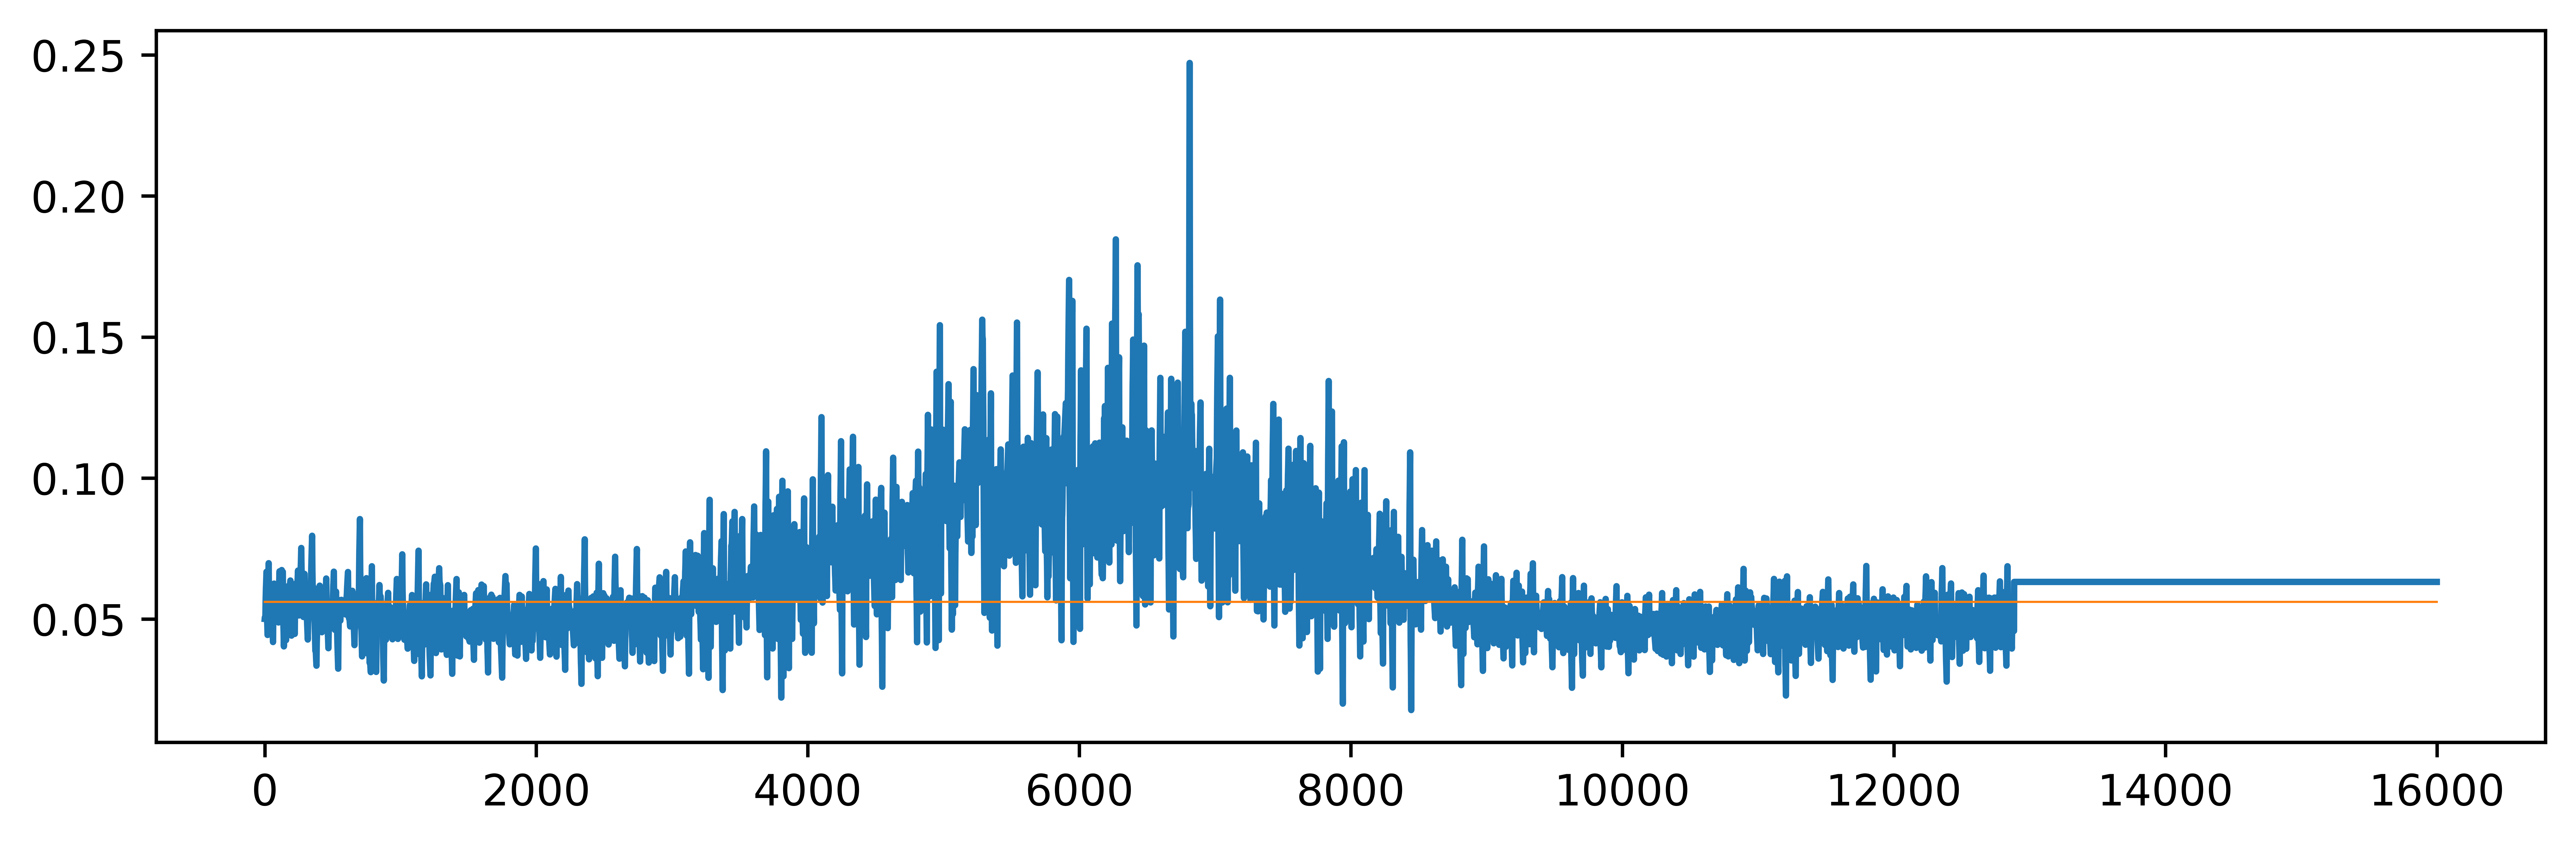

In [99]:
# Checking how the first sequence is learnt
for i in range(3):
    fig = plt.figure(figsize=(10,3), dpi=1200)
    plt.plot(outputs[i*17])
    plt.plot(x_train_pred[i*17],linewidth = 0.5)
    plt.show()

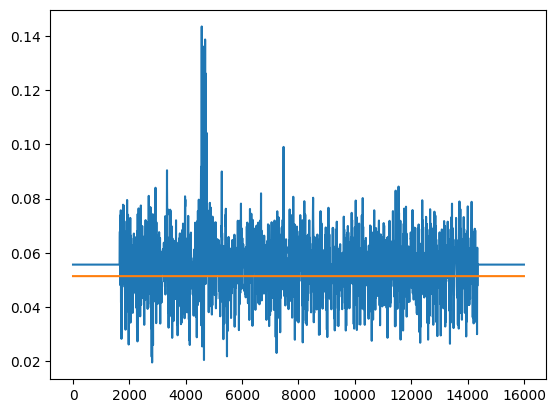

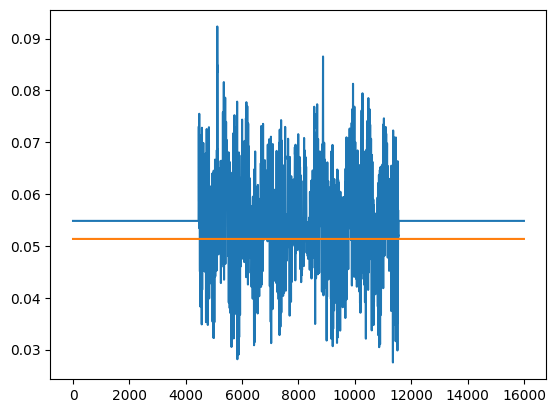

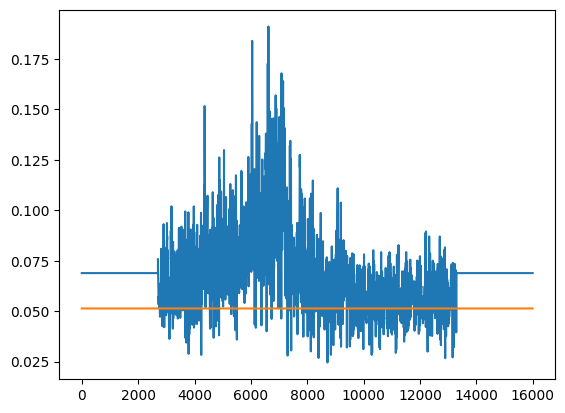

In [45]:
# Checking how the first sequence is learnt
for i in range(3):
    plt.plot(outputs[i*17])
    plt.plot(x_train_pred2[i*17])
    plt.show()

In [81]:
tin = tf.convert_to_tensor([np.zeros((16000,3)),np.ones((16000,3))],dtype=tf.float32)
test = model.predict(tin)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


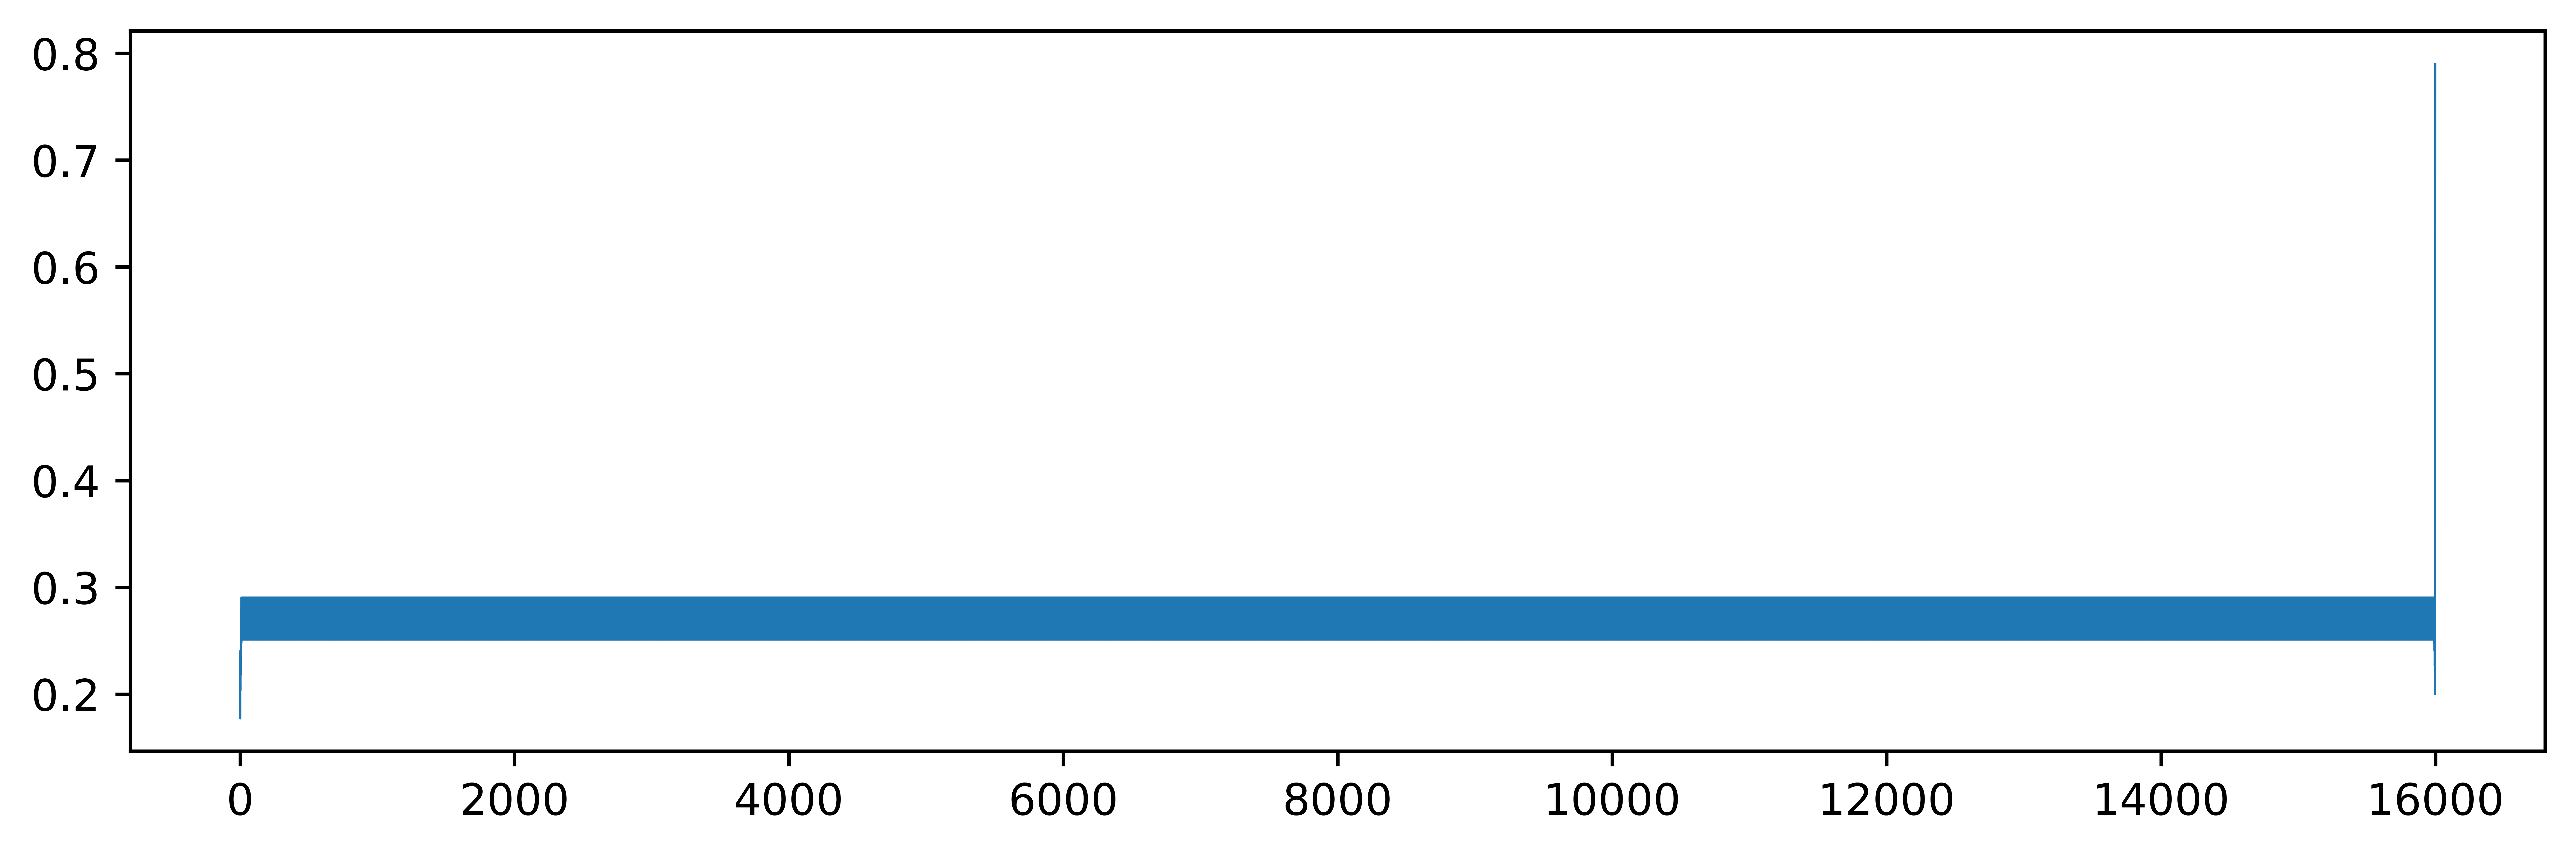

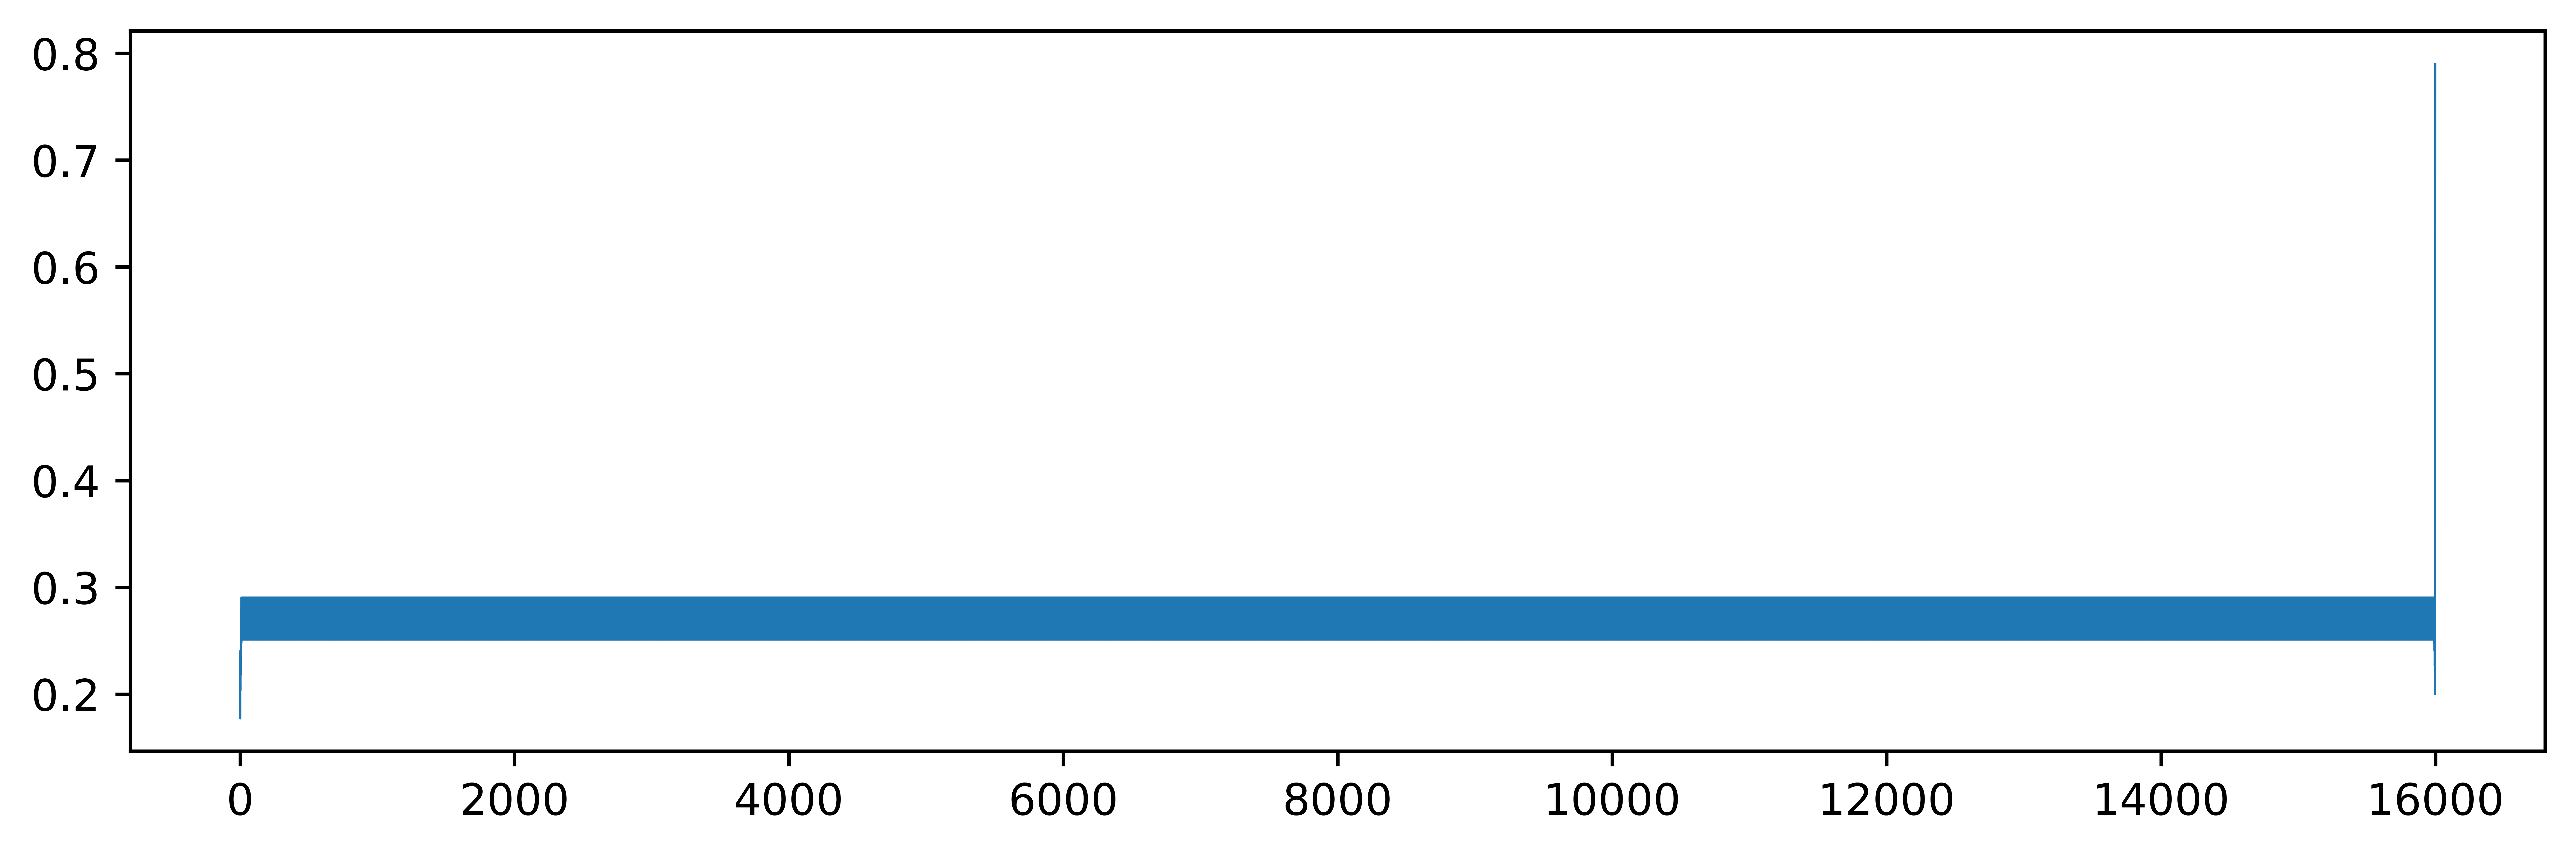

In [82]:

for i in range(2):
    fig = plt.figure(figsize=(10,3), dpi=1200)
    #plt.plot(outputs[i*17])
    plt.plot(test[i],linewidth = 0.5)
    plt.show()